#### title: "Strategies for Analyzing a 12-Gigabyte Data Set: Airline Flight Delays - Case Study Unit 14

output: html_notebook


#### Cory Adams, Chris Boomhower, Alexandra Fisher, Alex Frye
#### MSDS 7333, December 10, 2017

## Abstract

## Introduction

## Background

## Methods

## Results

# Batch Processing in R and Python
This is meant as a companion notebook for the the SMU MSDS program. Specifically, we will build off of chapter five in the text "Data Science in R", http://www.amazon.com/Data-Science-Approach-Computational-Reasoning/dp/1482234815.

In this notebook we will look at ways for loading and analyzing data out-of-core using a batch processing method. Specifically, we will be using the split-apply-combine approach with a few different APIs. In R, we will use:
- `bigmemory` for memory mapping the variables: https://cran.r-project.org/web/packages/bigmemory/index.html 
- `bigtabulate`
- `biganalytics`
- `doMC`

In python, we will also be using a number of different libraries 
- `pandas`
- `numpy`
- `graphlab-create`

___
# 1.0 Downloading the dataset (using python)
You can access descriptions of the data files from here: http://stat-computing.org/dataexpo/2009/the-data.html. You can manually download each of the zipped files OR run the following script to download the files into a folder in the same directory as this notebook called "Data".

In the following blocks of code, we download the data and then decompress the files into .csv files. Each csv contains data for one year of airline flights. 


Note: If you want an alternative R version for performing the download operations, see:
- http://www.cybaea.net/journal/2010/08/05/Big-data-for-R/

In [2]:
import os, sys
# create a Data directory if not done already
path = "/Airline/"
if not os.path.exists(path):
    os.mkdir( path, 0755 )
print(path)

/Airline/


In [ ]:
import urllib # this is part of the standard library for python
#from urllib.request import urlretrieve

years_to_download = range(1987,2009) # get the years 1987 through 2008
baseurl = 'http://stat-computing.org/dataexpo/2009/%d.csv.bz2' 

files = []
for year in years_to_download:
    # prepare strings
    url_of_data_file = baseurl%(year) # get the URL for the data file
    save_as_filename = path + '%d.csv.bz2'%(year) 
    # save as this
    files += [save_as_filename] # save name of the compressed file
    
    # download file
    print('Downloading %s to %s' % (url_of_data_file, save_as_filename)) # progress update
    urllib.urlretrieve(url_of_data_file, save_as_filename) #execute download
    
print(files)

In [ ]:
import bz2 # this is also part of the python standard library

# Now lets decompress all the files
for filename in files:#[path+'2006.csv.bz2',path+'2007.csv.bz2',path+'2008.csv.bz2']:
    # get file names
    filepath = filename
    newfilepath = filename[:-4]
    print('Decompressing', filepath,'to', newfilepath)
    
    # go through the decompressed chunks and write out to a decompressed file
    with open(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as file:
        for data in iter(lambda : file.read(100 * 1024), b''):
            new_file.write(data)

### If you want to delete the compressed files
Run the following block ONLY if you want to delets the compressed bz2 files from your system. 

In [ ]:
#!rm '/Users/darrenho/MSDSairline/'*.bz2

___
# 2.0 Loading data into memory
Now that the data has downloaded and been decompressed, we can load a single file into memory to ensure that everything decompressed correctly. For each file, we could load it into memory and then save the length of the file. Let's do this in both python and in R for two files (to keep runtime at a minimum). 

In [3]:
# Loading individual files in python
import pandas as pd
import numpy as np
import sys

total_length = 0

for year in [1987,1988]:
    # get file name of the csv
    # note that we can also load in the raw .bz2 file in python (or R) 
    # but the decompression step for these files sizes takes a huge performance hit
    csvfile = path+'/%d.csv'%(year)
    print('loading', csvfile)
    sys.stdout.flush()
    
    # read the file and increment the lines count
    %time df = pd.read_csv(csvfile) # note that this is a big operation, especially since we just want the length
    # one way of making this shorter is to filter which columns we are loading
    
    total_length += len(df)

print('Answer from python:', total_length)
df.head()

('loading', '/Airline//1987.csv')
CPU times: user 3.94 s, sys: 367 ms, total: 4.31 s
Wall time: 4.31 s
('loading', '/Airline//1988.csv')
CPU times: user 15.4 s, sys: 1.4 s, total: 16.8 s
Wall time: 16.8 s
('Answer from python:', 6513922)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1988,1,9,6,1348.0,1331,1458.0,1435,PI,942,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1988,1,10,7,1334.0,1331,1443.0,1435,PI,942,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1988,1,11,1,1446.0,1331,1553.0,1435,PI,942,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1988,1,12,2,1334.0,1331,1438.0,1435,PI,942,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1988,1,13,3,1341.0,1331,1503.0,1435,PI,942,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [4]:
print('CSV File Format')
!head '/Airline/1987.csv'

CSV File Format
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,NA,23,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,NA,14,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,NA,29,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,NA,-2,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,19,1,749,730,922,849,PS,1451,NA,93,79,NA,33,19,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,21,3,728,730,848,849,PS,1451,NA,80,79,NA,-1,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,22,4,728,730,852,849,PS,1451,NA,84,79,NA,3,-2,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1987,10,23,5,731,730

___
So now we can see that there were about 6.5M different entries in the years 1987 and 1988. However, we really want to be working with one really large descriptor of all years, rather than loading up each year from disc each time. Actually, the operations we had above are much more appropriate for a SQL query, but they are not quite as scalable for some of the other analyses that we want to do later on. 

The python code is noticeably faster at loading in the data, so let's use python to pre-process the csv files and make sure all the data is an integer. All the text data must be coded as numeric (an integer) when we use R's big memory package, so lets go file by file and make sure its ready to use with R.


## 2.1 Preprocessing Data in Chunks
In order to replace all the strings in the data frame, we first need to know exactly all the unique strings contained in each column. The first block takes a pass on all the data and finds all the unique string entries in the entire dataset. This means loading all the data files in one pass and concatenating the unique entries into a data structure. I have chosen to use a dictionary as the data structure with the name of each key in the dictionary being the column name of the variable we want to convert to an integer. The value of the key is a `set` of strings. 

Once we have this dataset, we can then replace the unique values properly (we will need to load the data files again!!). We can then replace the values with an integer. After replacing them, we can resave the data frame as a csv. Phew!

Please note that the runtime of these blocks aggregates to ~60 minutes (or more) depending on your system. If you want an alternative implementation using R only, please see:
- http://www.cybaea.net/journal/2010/08/05/Big-data-for-R/

In [6]:
# In this data, there are multiple variables that are objects
# these need to be appropriately converted to numbers (integers) 
# To do this, we must know the unique values in each of the columns, let's do this first
import pandas as pd
import numpy as np
import sys
import time
# cPickle is standard on 2.x
import cPickle as pickle
# _pickle works on Python 3.x
#import _pickle as pickle

unique_values = {} # create an empty dictionary of the column name an the unique values in it
for year in range(1987,2009):
    t = time.time()
    # get file name of the csv
    csvfile = path+'%d.csv'%(year)
    print('loading',csvfile,)
    sys.stdout.flush()
    
    # read the file
    df = pd.read_csv(csvfile,usecols=['Origin', 'Dest', 'UniqueCarrier','TailNum','CancellationCode']) 
    #df = df.select_dtypes(exclude=['float64','int64']) # grab only the non-numeric data
    
    print('...finding unique values',)
    sys.stdout.flush()
    
    for col in df.columns:
        print(col)
        # check to see if we have seen this column before
        s = set(df[col].values.astype(np.str))
        if col not in unique_values:
            # if not, then create a key with the unique values for that column in it
            unique_values[col] = s
        else:
            # otherwise make sure that the remaining columns are unique
            unique_values[col] |= s
            
    print('...finished, %.2f seconds'%(time.time()-t))
    sys.stdout.flush()
    del df

# Save out the dictionary for later use
pickle.dump( unique_values, open( path+'unique_mapping.p', "wb" ) )

('loading', '/Airline/1987.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 2.82 seconds
('loading', '/Airline/1988.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 11.24 seconds
('loading', '/Airline/1989.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 10.19 seconds
('loading', '/Airline/1990.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 10.59 seconds
('loading', '/Airline/1991.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 10.25 seconds
('loading', '/Airline/1992.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 10.29 seconds
('loading', '/Airline/1993.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 10.10 seconds
('loading', '/

/Users/coryadams/anaconda/envs/gl-env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


('loading', '/Airline/2004.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 14.45 seconds
('loading', '/Airline/2005.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 15.96 seconds
('loading', '/Airline/2006.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 14.80 seconds
('loading', '/Airline/2007.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 15.24 seconds
('loading', '/Airline/2008.csv')
('...finding unique values',)
UniqueCarrier
TailNum
Origin
Dest
CancellationCode
...finished, 14.52 seconds


In [7]:
# let's take a look at the dictionary
print(unique_values.keys())
print('Cancellation Code:',unique_values['CancellationCode'])
print('UniqueCarrier:',unique_values['UniqueCarrier'])

['Origin', 'TailNum', 'UniqueCarrier', 'Dest', 'CancellationCode']
('Cancellation Code:', set(['A', 'C', 'B', 'D', 'nan']))
('UniqueCarrier:', set(['DL', 'DH', 'WN', 'HP', 'HA', 'FL', 'YV', 'PS', 'TZ', 'TW', '9E', 'PA (1)', 'PI', 'NW', 'AA', 'CO', 'EA', 'XE', 'AQ', 'AS', 'EV', 'ML (1)', 'OO', 'OH', 'F9', 'US', 'B6', 'MQ', 'UA']))


In [13]:
!pip install numpy --upgrade
!pip install pandas --upgrade

The directory '/Users/coryadams/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/coryadams/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement already up-to-date: numpy in /Users/coryadams/anaconda/envs/gl-env/lib/python2.7/site-packages
The directory '/Users/coryadams/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/coryadams/Library/Caches/pip' or its parent directory is not owned by the current user and c

In [17]:
def fast_numpy_replace(np_vector,replace_set):
    # you can look at this function at your leisure, but essentially we use fast set 
    # comparison to try and speed up the analysis
    replace_set = np.array(list(replace_set)) # get "possible values" as a numpy array
    n = np.ndarray(np_vector.shape).astype(np.float64) # fill in this matrix
    
    vector_as_set,idx_back = np.unique(np_vector,return_inverse=True) # get the unique indices and locations
    
    # now loop through the unique values for this dataset
    for idx,val in enumerate(vector_as_set):
        # find what number this should be (like a hash)
        category_num = np.nonzero(replace_set == val)[0][0]
        n[idx_back==idx] = category_num # set the values as this category, vectorize for speed
        
    return n.astype(np.float64)
    
fileHandle = open(path+'AirlineDataAll.csv', 'w') # open and replace if needed
years = range(1987,2009)
for year in years:
    t = time.time()
    
    # get file name of the csv
    csvfile = path+'%d.csv'%(year)
    print('Running...',csvfile,)
    sys.stdout.flush()
    
    # read the file
    df = pd.read_csv(csvfile) 
    
    print('loaded, ...replacing values',)
    sys.stdout.flush()
        
    # now replace the matching columnar data with the proper number category
    for key in unique_values.keys():
        if key in df:
            print(key[0:4],)
            sys.stdout.flush()
            tmp = df[key].values.astype(np.str)
            df[key] = fast_numpy_replace(tmp,unique_values[key])
     
    print('...',)
    sys.stdout.flush()
    
    for col in df:
        #df[col] = np.round(df[col].astype(np.float64)) # use floats to keep the nan's inline with numpy representation
        df[col] = df[col].astype(np.float64).round(2) 

    print('writing',)
    sys.stdout.flush()
    
    # these lines make one large file with the numeric data
    # it also solves a problem with pandas closing the file that takes an inordinate amount of time
    # NOTE: using binary here would be a huge speedup, but I am not sure about the binary structure of the 
    # backing file for bigmatrix, so we stick with CSV
    # TODO: find out if the backing file is just a dump of the c struct to file
    if year==years[0]:
        df.to_csv(fileHandle,index=False, index_label=False, na_rep="NA",float_format='%.0f')
    else:
        df.to_csv(fileHandle, mode='a', header=False, index=False, index_label=False,  na_rep="NA", float_format='%.0f')
        
    print(', %.2f sec.'%(time.time()-t))
    del df

print('closing file',)
sys.stdout.flush()

fileHandle.close()
print('...Done')

('Running...', '/Airline/1987.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 54.20 sec.
('Running...', '/Airline/1988.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 210.25 sec.
('Running...', '/Airline/1989.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 201.28 sec.
('Running...', '/Airline/1990.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 210.23 sec.
('Running...', '/Airline/1991.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 201.80 sec.
('Running...', '/Airline/1992.csv')
('loaded, ...replacing values',)
('Orig',)
('Tail',)
('Uniq',)
('Dest',)
('Canc',)
('...',)
('writing',)
, 202.20 sec.
('Running...', '/Airline/1993.csv')
('loaded, ...replacing values',)
('

In [19]:
# now lets take a look to see what has actually changed in the file
# let's load the head of 1987 and the big CSV file to see how they compare

#this will fail for Windows, not supported
print('New File Format:')
!head '/Airline/AirlineDataAll.csv'
print('')
print('Old File Format')
!head '/Airline/2008.csv'

New File Format:
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1987,10,14,3,741,730,912,849,7,1451,9719,91,79,NA,23,11,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,15,4,729,730,903,849,7,1451,9719,94,79,NA,14,-1,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,17,6,741,730,918,849,7,1451,9719,97,79,NA,29,11,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,18,7,729,730,847,849,7,1451,9719,78,79,NA,-2,-1,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,19,1,749,730,922,849,7,1451,9719,93,79,NA,33,19,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,21,3,728,730,848,849,7,1451,9719,80,79,NA,-1,-2,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,22,4,728,730,852,849,7,1451,9719,84,79,NA,3,-2,172,202,447,NA,NA,0,4,0,NA,NA,NA,NA,NA
1987,10,23,5,731,73

In [20]:
# let's now look at the tail of our big dataset and the tail of the 2008 file
# do they compare nicely?

#this will fail for Windows, not supported
print('New File Format:')
!tail '/Airline/AirlineDataAll.csv'
print('')
print('Old File Format:')
!tail '/Airline/2008.csv'

New File Format:
2008,12,13,6,1007,847,1149,1010,0,1631,2497,162,143,122,99,80,251,20,689,8,32,0,4,0,1,0,19,0,79
2008,12,13,6,638,640,808,753,0,1632,10676,90,73,50,15,-2,130,255,270,14,26,0,4,0,0,0,15,0,0
2008,12,13,6,756,800,1032,1026,0,1633,959,96,86,56,6,-4,304,255,425,23,17,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,612,615,923,907,0,1635,2826,131,112,103,16,-3,53,272,546,5,23,0,4,0,0,0,16,0,0
2008,12,13,6,749,750,901,859,0,1636,9994,72,69,41,2,-1,180,255,215,20,11,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,1002,959,1204,1150,0,1636,9994,122,111,71,14,3,251,21,533,6,45,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,834,835,1021,1023,0,1637,10045,167,168,139,-2,-1,251,185,874,5,23,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,655,700,856,856,0,1638,12867,121,116,85,0,-5,235,255,545,24,12,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,1251,1240,1446,1437,0,1639,9994,115,117,89,9,11,21,255,533,13,13,0,4,0,NA,NA,NA,NA,NA
2008,12,13,6,1110,1103,1413,1418,0,1641,10045,123,135,104,-5,7,181,255,874,8,11,0,4,0,NA,NA,NA,NA,NA

Old File Format:
20

___
In the above code, we also created a large file with all the data from every year inside of it. This is now saved as `AirlineDataAll`. Let's take a look at it.

In [22]:
#Windows does't have ls command
!ls -all '/Airline/' *All.csv 

ls: *All.csv: No such file or directory
/Airline/:
total 49754984
drwxr-xr-x  48 root  wheel         1632 Dec  7 16:44 .
drwxr-xr-x  33 root  wheel         1190 Dec  7 16:02 ..
-rw-r--r--   1 root  wheel    127162942 Dec  7 16:10 1987.csv
-rw-r--r--   1 root  wheel     12652442 Dec  7 16:02 1987.csv.bz2
-rw-r--r--   1 root  wheel    501039472 Dec  7 16:10 1988.csv
-rw-r--r--   1 root  wheel     49499025 Dec  7 16:03 1988.csv.bz2
-rw-r--r--   1 root  wheel    486518821 Dec  7 16:11 1989.csv
-rw-r--r--   1 root  wheel     49202298 Dec  7 16:03 1989.csv.bz2
-rw-r--r--   1 root  wheel    509194687 Dec  7 16:11 1990.csv
-rw-r--r--   1 root  wheel     52041322 Dec  7 16:03 1990.csv.bz2
-rw-r--r--   1 root  wheel    491210093 Dec  7 16:11 1991.csv
-rw-r--r--   1 root  wheel     49877448 Dec  7 16:03 1991.csv.bz2
-rw-r--r--   1 root  wheel    492313731 Dec  7 16:12 1992.csv
-rw-r--r--   1 root  wheel     50040946 Dec  7 16:03 1992.csv.bz2
-rw-r--r--   1 root  wheel    490753652 Dec  7 16:12 19


___
# 4.0 Analyzing the data using only Python
Now let's analyze the data using graphlab create (from the company Dato). As you have seen before, the graphlab-create API uses something called a scalable data frame (or SFrame) that handles all of the out-of-core memory management for you. It is by far one of the most optimized tools for handling table data out-of-core. Really. With that said, lets also give a list of what to expect:
- Loading and saving large amounts of data will be very fast
- Manipulating and adding columns is not much overhead, as everything is saved piece meal
- Parallelization is mostly handled for you in the background
- Operations are 'queued up' before execution, so that they can be simplified and parallelized (if possible and easy)
- However, there will be slightly less flexibility in the split-apply-combine technique
 - We need to use premade aggregation function from Dato's API 
 - That means we can't just write a custom function to work in parallel on the different groups (like in R)
 - But we can concatenate operations to perform rich analysis (albeit not using standard python syntax)
 - In my opinion, this is the biggest downside (that custom aggregators cannot be built), but future version of graphlab might start to support this
- Grouping and applying cannot be separated from each other 
 - This is because of the queueing of operations, grouping does not happen until absolutely neccessary 
 - This also optimizes the memory management, which can be a huge time savings
- We CAN write custom apply functions that work on each row of data (just not the grouped splits)
- At the time of writing this, graphlab is only supported for python 2.7 (ouch!)
 - This is unfortunate because graphlab is the only reason I am not updating to python 3 ...
- Support on windows is really good, but mac/linux is slightly better.
 - This is especially true when using Dato's numpy extensions (which only works on mac/linux)
 - And the extensions make numpy operations completely usable out-of-core, with many operations optimized for sequential access (slightly more optimized than Numpy's builtin memmap)


## 4.1 Loading 12GB of Data in Python
Alright, then. Let's load up graphlab in order to get an idea about the power of this tool and what the syntax looks like.

In [23]:
#pip install graphlab-create
#pip install graphlab-create --upgrade
#conda install -c graphlab-create

import graphlab as gl

In [25]:
#Here I needed to register (https://turi.com/register) and upgrade my graphlab using a free, academic-use-only product key: 

# pip install --upgrade --trusted-host pypi.python.org graphlab-create 
# pip install --upgrade --no-cache-dir --trusted-host get.graphlab.com https://get.graphlab.com/GraphLab-Create/2.1/dhomrighausen@smu.edu/A6C0-BEA7-AEF2-0822-AC94-D968-B66F-5B74/GraphLab-Create-License.tar.gz
sf = gl.SFrame('/Airline/AirlineDataAll.csv')

Finished parsing file /Airline/AirlineDataAll.csv

Parsing completed. Parsed 100 lines in 0.807712 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,int,int,int,int,int,int,int,int,str,int,int,int,int,int,str,str,int,int,int,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 541148 lines. Lines per second: 333682

Read 4357653 lines. Lines per second: 588776

Read 8162533 lines. Lines per second: 628658

Read 11965516 lines. Lines per second: 645030

Read 15775671 lines. Lines per second: 653052

Read 19574723 lines. Lines per second: 658704

Read 23371994 lines. Lines per second: 662025

Read 27169062 lines. Lines per second: 664968

Read 30973522 lines. Lines per second: 667075

Read 34767102 lines. Lines per second: 669078

Read 38566409 lines. Lines per second: 669317

Read 42387282 lines. Lines per second: 669480

Read 45668789 lines. Lines per second: 668071

Read 48935611 lines. Lines per second: 664851

Read 52207736 lines. Lines per second: 660885

Read 55473493 lines. Lines per second: 657791

Read 58732103 lines. Lines per second: 653998

Read 62004894 lines. Lines per second: 650823

Read 65260703 lines. Lines per second: 647234

Read 68523240 lines. Lines per second: 643935

Read 71771543 lines. Lines per second: 640753

Read 75030942 lines. Lines per second: 637481

Read 77736095 lines. Lines per second: 631842

Read 80438119 lines. Lines per second: 625627

Read 83681517 lines. Lines per second: 623170

Read 86517396 lines. Lines per second: 616182

Read 89353845 lines. Lines per second: 610017

Read 91633751 lines. Lines per second: 604895

Read 93904667 lines. Lines per second: 600173

Read 96744114 lines. Lines per second: 594669

Read 99589820 lines. Lines per second: 589964

Read 102418299 lines. Lines per second: 585216

Read 104694628 lines. Lines per second: 581483

Read 106969613 lines. Lines per second: 577975

Read 109791760 lines. Lines per second: 574193

Read 112065457 lines. Lines per second: 571041

Read 114339392 lines. Lines per second: 568200

Read 117132141 lines. Lines per second: 565173

Read 119858906 lines. Lines per second: 562516

Read 122571182 lines. Lines per second: 560117

Finished parsing file /Airline/AirlineDataAll.csv

Parsing completed. Parsed 123534969 lines in 220.785 secs.

Wow! That was really fast to read the entire csv structure! On my system, it took about 6 minutes to prepare the SFrame. But--is it really the same length as the data we saw above? How could this be 5 times faster than the R code for loading and parsing the data? Let's check the dimensions.

In [26]:
sf.shape

(123534969, 29)

...Yes. It is the same size! And if we dump this to file, it will be compressed to under 2GB and be written in about a minute to disk (and almost instantaneously when read--just like R). That's a really great advantage when working with large data like this. The space/time tradeoffs have really been optimized for this package. 

It also means that file access is quicker because the DiskIO has to load fewer bytes. It needs to decompress the bytes, but it does so typically much quicker than it would be to read them from disk. Impressive!

If you wanted to save it, you could say:
- ```sf.save('/Users/darrenho/MSDSairline/airline_data_sframe_directory') # write out as binary compressed file (very compressed)```
- Then to load it back up:
 - ```gl.load_sframe('/Users/darrenho/MSDSairline/airline_data_sframe_directory')```
 
___

## 4.2 Preprocessing the CSV data in Python with Graphlab
So great, we can load up the same file as R did. It still took forever to preprocess that file and get it ready. So, we really want to answer this question:
**Is there an easier way to preprocess and concatenate all the files into one memory map using SFrames?** 

SFrames are more forgiving in terms of the data types that they can hold. Moreover, they load much more quickly than the parser used by `pandas`. Maybe we should try to read in each of the original CSV files as SFrames and concatenate them together into one SFrame. Would this be a quicker way to create the memory mapped file than all the preprocessing we did above?

The answer is, in fact, **yes**. It is much faster and the code is much easier to understand than what we performed earlier. And because `graphlab` supports more than one data type, we do not need to preprocess any of the data. Plus, when we write out to file, it happens more quickly and in a compressed version (on disk it will be compressed to about 2GB). 

Here is the code to perform all the concatenation we did earlier. I am also supplying graphlab with the data type for each column to ensure that the data is consistent. However, if I did not, Graphlab would try and guess the data type based on the first 100 lines of the csv file.

In [28]:
del sf # get rid of the old thing
# What about just loading up all the data using the SFrame Utility for loading CSV files?
# We will need to make sure that the SFrame has consistent datatypes, so we will give the value for each header
column_hints=[int,int,int,int,int,int,int,int,str,int,str,int,int,int,int,int,str,str,int,int,int,int,str,int,int,int,int,int,int]

t = time.time()
# now load the first SFrame
sf = gl.SFrame() #.read_csv('Data/1987.csv',column_type_hints=column_hints)

# and then append each SFrame in a for loop
for year in range(1987,2009):
    print 'read %d lines, reading next file %d.csv'%(sf.shape[0],year)
    sys.stdout.flush()
    sftmp = gl.SFrame.read_csv('/Airline/%d.csv'%(year),column_type_hints=column_hints)
    sf = sf.append(sftmp)

print 'It took %.2f seconds to concatenate the memory mapped file'%(time.time()-t)

t = time.time()
print 'Saving...',
sf.save('/Airline/airline_data_sframe_directory') # save a compressed version of this SFrame
print 'took %.2f seconds'%(time.time()-t),'Shape of SFrame is',sf.shape

read 0 lines, reading next file 1987.csv


Read 540959 lines. Lines per second: 332933

Finished parsing file /Airline/1987.csv

Parsing completed. Parsed 1311826 lines in 2.60295 secs.

read 1311826 lines, reading next file 1988.csv


Read 1638298 lines. Lines per second: 475948

Read 4902327 lines. Lines per second: 577168

Finished parsing file /Airline/1988.csv

Parsing completed. Parsed 5202096 lines in 8.83243 secs.

read 6513922 lines, reading next file 1989.csv


Read 2179541 lines. Lines per second: 531293

Finished parsing file /Airline/1989.csv

Parsing completed. Parsed 5041200 lines in 8.3878 secs.

read 11555122 lines, reading next file 1990.csv


Read 545116 lines. Lines per second: 330162

Read 3810010 lines. Lines per second: 553675

Finished parsing file /Airline/1990.csv

Parsing completed. Parsed 5270893 lines in 9.4512 secs.

read 16826015 lines, reading next file 1991.csv


Read 543797 lines. Lines per second: 264490

Read 3259409 lines. Lines per second: 442544

Finished parsing file /Airline/1991.csv

Parsing completed. Parsed 5076925 lines in 10.3717 secs.

read 21902940 lines, reading next file 1992.csv


Read 544035 lines. Lines per second: 261772

Read 3806600 lines. Lines per second: 476606

Finished parsing file /Airline/1992.csv

Parsing completed. Parsed 5092157 lines in 10.1228 secs.

read 26995097 lines, reading next file 1993.csv


Read 1086617 lines. Lines per second: 463179

Read 4877507 lines. Lines per second: 630122

Finished parsing file /Airline/1993.csv

Parsing completed. Parsed 5070501 lines in 7.96171 secs.

read 32065598 lines, reading next file 1994.csv


Read 2715338 lines. Lines per second: 565023

Finished parsing file /Airline/1994.csv

Parsing completed. Parsed 5180048 lines in 8.24416 secs.

read 37245646 lines, reading next file 1995.csv


Read 527246 lines. Lines per second: 306141

Read 3692144 lines. Lines per second: 528988

Finished parsing file /Airline/1995.csv

Parsing completed. Parsed 5327435 lines in 9.5181 secs.

read 42573081 lines, reading next file 1996.csv


Read 530202 lines. Lines per second: 309433

Read 3689352 lines. Lines per second: 523890

Finished parsing file /Airline/1996.csv

Parsing completed. Parsed 5351983 lines in 10.22 secs.

read 47925064 lines, reading next file 1997.csv


Read 529207 lines. Lines per second: 281422

Read 3684987 lines. Lines per second: 517054

Finished parsing file /Airline/1997.csv

Parsing completed. Parsed 5411843 lines in 9.83493 secs.

read 53336907 lines, reading next file 1998.csv


Read 528414 lines. Lines per second: 315416

Read 3680636 lines. Lines per second: 534637

Finished parsing file /Airline/1998.csv

Parsing completed. Parsed 5384721 lines in 9.84999 secs.

read 58721628 lines, reading next file 1999.csv


Read 524911 lines. Lines per second: 308576

Read 3677577 lines. Lines per second: 528797

Finished parsing file /Airline/1999.csv

Parsing completed. Parsed 5527884 lines in 9.85906 secs.

read 64249512 lines, reading next file 2000.csv


Read 524495 lines. Lines per second: 301173

Read 3143838 lines. Lines per second: 471044

Finished parsing file /Airline/2000.csv

Parsing completed. Parsed 5683047 lines in 10.9961 secs.

read 69932559 lines, reading next file 2001.csv


Read 522034 lines. Lines per second: 269870

Read 3132289 lines. Lines per second: 450710

Read 5735547 lines. Lines per second: 480259

Finished parsing file /Airline/2001.csv

Parsing completed. Parsed 5967780 lines in 12.2727 secs.

read 75900339 lines, reading next file 2002.csv


Read 2089436 lines. Lines per second: 499428

Finished parsing file /Airline/2002.csv

Parsing completed. Parsed 5271359 lines in 9.14194 secs.

read 81171698 lines, reading next file 2003.csv


Read 522593 lines. Lines per second: 323950

Read 3730099 lines. Lines per second: 534804

Finished parsing file /Airline/2003.csv

Parsing completed. Parsed 6488540 lines in 11.7168 secs.

read 87660238 lines, reading next file 2004.csv


Read 560245 lines. Lines per second: 304504

Read 3357994 lines. Lines per second: 466208

Read 6147859 lines. Lines per second: 481717

Finished parsing file /Airline/2004.csv

Parsing completed. Parsed 7129270 lines in 14.5416 secs.

read 94789508 lines, reading next file 2005.csv


Read 1119468 lines. Lines per second: 390843

Read 3917795 lines. Lines per second: 471778

Read 6700868 lines. Lines per second: 485725

Finished parsing file /Airline/2005.csv

Parsing completed. Parsed 7140596 lines in 14.5356 secs.

read 101930104 lines, reading next file 2006.csv


Read 1676459 lines. Lines per second: 429510

Read 4471997 lines. Lines per second: 476900

Finished parsing file /Airline/2006.csv

Parsing completed. Parsed 7141922 lines in 14.546 secs.

read 109072026 lines, reading next file 2007.csv


Read 559204 lines. Lines per second: 299573

Read 3348410 lines. Lines per second: 457478

Read 6128354 lines. Lines per second: 473887

Finished parsing file /Airline/2007.csv

Parsing completed. Parsed 7453215 lines in 15.4832 secs.

read 116525241 lines, reading next file 2008.csv


Read 535634 lines. Lines per second: 301666

Read 3211046 lines. Lines per second: 458880

Read 5874437 lines. Lines per second: 477085

Finished parsing file /Airline/2008.csv

Parsing completed. Parsed 7009728 lines in 14.5605 secs.

It took 253.66 seconds to concatenate the memory mapped file
Saving... took 49.35 seconds Shape of SFrame is (123534969, 29)


So yeah, we concatenated and loaded the file in ~320 seconds and saved a compressed binary version in about 1 minute (on my machine). That's quite a speedup. 

But can we perform operations upon it? Let's check how versatile these data structures are. Let's first try to replicate the functionality of finding the most popular airports to fly out of, like we did with `bigmemory`. 

In [31]:
# CONVENIENCE BLOCK FOR THOSE LOADING FROM DISK HERE

# If you have already run the notebook above and just want to load up the data
# then you can reload the SFrame here
import graphlab as gl

sf = gl.load_sframe('/Airline/airline_data_sframe_directory')

## 4.3 Analyzing popular Airports to fly from in Python
We now need to perform some operations using the split-apply-combine technique. However, in graphlab this all happens via one syntax (the `groupby` function). Let's see how it works. 

In [32]:
# to perform grouping and splitting
# we need to specify (1) which column(s) to group the SFrame using, and 
#                    (2) what function we want to perform on the group
# in graphlab, we only have a few options for performing on each of the groups. 
# Here, lets keep it simple--let's group by the airport origin and then
#  use the builtin 'count' function to aggregate the results
# The result is another SFrame with the Unique origin names as a column and the
#  number of entries in each group in another column
%time sf_counts = sf.groupby('Origin', {'num_flights':gl.aggregate.COUNT()})
sf_counts

CPU times: user 56.4 s, sys: 590 ms, total: 57 s
Wall time: 7.79 s


Origin,num_flights
ABY,8035
ATL,6100953
TEX,683
VLD,7300
CHS,222491
MKK,289
ROR,2228
VCT,2445
ITH,18397
LAW,18019


/Users/coryadams/anaconda/envs/gl-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


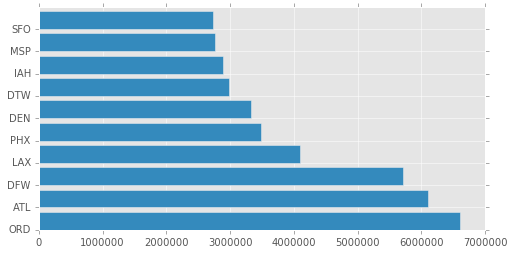

In [33]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')

# As seen above, the sf_counts SFrame has the origin of the flight on the left
# and the count of flights on the right 

# let's grab the top 10 entries
sf_top = sf_counts.topk('num_flights',10) # this is builtin command in graphlab

airports = np.array(sf_top['Origin'])
counts = np.array(sf_top['num_flights'])

fig = plt.figure(figsize=(8,4))
plt.barh(range(len(counts)),counts)

# and set them on the plot
plt.yticks(range(len(airports)), airports)

plt.show()

___

## 4.4 Analyzing Depature Delays at Specific Times of the Day in Python
Now, let's try to do something a little more interesting, such as trying to perform the same operations that are in the Nolan text. Specifically, let's try to find the percentiles for late flights based upon the hour of the day that they depart. To do this we will:
- Create a new column for the hour of the day that a plane departed.
- Fix the `hours==24` and `hours==0` to be consistent
- Group by the hours of departure 
- Take percentiles of each group to see which ones are the latest

In [34]:
from math import floor
# first, let's create a new column in this SFrame that has the departure time floored to the nearest hour
sf['DepTimeByHour'] = sf['CRSDepTime'].apply(lambda x: floor(x/100),dtype=int)
sf['DepTimeByHour'] # and print a few of them (note: the column has not been evaluated yet)

dtype: int
Rows: 123534969
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 8, 8, 8, 8, 8, ... ]

In [35]:
# Let's now change the hours of the day that are equal to 24
# we need to be careful here becasue each column is not immutable
# in pandas this would be:
#    df.DepTimeByHour[df.DepTimeByHour==24] = 0
# but we cant just change a few values in the column, we need to change them all and replace them
# don't worry though, Graphlab does this smartly
sf['DepTimeByHour'] = sf['DepTimeByHour'].apply(lambda x: 0 if x==24 else x)
# again, this column has not been evaluated yet because that value has not yet been accessed

In [36]:
# now lets group the SFrame by the hours and calculate the percentiles of each group
# here is where the lazy evaluation actually happens so this takes a little while to compute

# the groupby function will partition our SFrame into groups based upon the given column of data
# next, we need to tell graphlab what operations to perform on the group and what rows
# to do that, we send in a dictionary of names and 'operations' 
# We did a similar operation above with the 'COUNT' aggregator
# there are only a certain number of operators we can choose from, we will choose to use the 'QUANTILE'
#   aggregator on the column 'DepDelay'. We want to take the percentiles [0.90,0.99,0.999,0.9999]
# We can also perform other operations by adding entries in the dictonary
# So we will also take the 'MAX' of each group
import time
t = time.time()
delay_sf = sf.groupby('DepTimeByHour', 
                            {'delay_quantiles':gl.aggregate.QUANTILE('DepDelay', [0.90,0.99,0.999,0.9999]),
                             'delay_max':gl.aggregate.MAX('DepDelay')})
# this returns a new SFrame with the specified columns from each aggregation

print 'Took %.2f seconds to run'%(time.time()-t)

Took 111.59 seconds to run


In [37]:
# sort it by when departed and display it
delay_sf = delay_sf.sort('DepTimeByHour')
delay_sf

DepTimeByHour,delay_max,delay_quantiles
0,1435,"[30.0, 133.0, 1435.0,1435.0] ..."
1,1419,"[20.0, 98.0, 199.0,1419.0] ..."
2,1265,"[10.0, 82.0, 187.0,1265.0] ..."
3,976,"[7.0, 97.0, 200.0, 976.0]"
4,930,"[9.0, 101.0, 930.0,930.0] ..."
5,1418,"[5.0, 81.0, 1418.0,1418.0] ..."
6,1740,"[6.0, 79.0, 1740.0,1740.0] ..."
7,1956,"[9.0, 84.0, 1956.0,1956.0] ..."
8,2119,"[14.0, 93.0, 2119.0,2119.0] ..."
9,1800,"[17.0, 95.0, 1800.0,1800.0] ..."


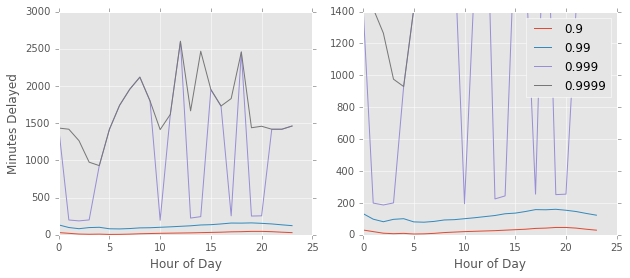

In [38]:
# to use matplotlib, we need to convert over to numpy arrays
# this is a fine operation because the new aggregated SFrame we are 
# working (delay_sf) with is quite small
x = np.array(delay_sf['DepTimeByHour'])
y = np.array(delay_sf['delay_quantiles'])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x,y)
plt.ylabel('Minutes Delayed')
plt.xlabel('Hour of Day')


plt.subplot(1,2,2)
plt.plot(x,y)
plt.xlabel('Hour of Day')
plt.ylim(0,1400) # make the same axes as in the book
plt.legend(['0.9','0.99','0.999','0.9999'])

plt.show()

Oh no! This doesn't look like the graph from the book at all!! Actually, there is a really great reason for that...

Let's investigate further. The bottom two lines (percentiles 0.90 and 0.99) look very similar to what your book had, but the other two percentile values (0.999 and 0.9999) seemingly did not evaluate properly. 

Find out why by looking at the documentation for the quartile aggregator.
- https://dato.com/products/create/docs/graphlab.data_structures.aggregation.html#module-graphlab.aggregate
- Hint: there is a reason that the quantile calculation was really, really, really fast.
___

## 4.5 Calculate Plane Age with Dato
So let's keep moving and try to calculate the plane's age like we did in R.

In [39]:
# only use years where the tail number was recorded
# we can manipulate the SFrame fairly easily in graphlab, so let's do it
sf_tmp = sf[['TailNum','Year','Month','DepDelay']][sf['Year']>1994]

In [40]:
# lets try to make a function for getting the age of the plane
# First lets just save the plane's age in years
sf_tmp['FlightAge'] = 12*sf_tmp['Year']+sf_tmp['Month']-1

# and take the minimum of that in order to get its first flight
t = time.time()
sf_min_ages = sf_tmp[['TailNum','FlightAge']].groupby('TailNum',{'FirstFlight':gl.aggregate.MIN('FlightAge')})
print 'Took %.2f seconds to run'%(time.time()-t)

Took 10.12 seconds to run


In [41]:
# Now transform the FirstFlight Column into the original dataframe size
# to do that we can just do a join on a few columns of our sf
# this will save the flight age and the minimum in a new SFrame
%time sf_fewcols = sf_tmp[['TailNum','FlightAge']].join(sf_min_ages,on='TailNum',how='left') # long operation

CPU times: user 8min 50s, sys: 1.8 s, total: 8min 51s
Wall time: 1min 12s


In [42]:
# and now we can simply subtract the new calculated quantity and add to the original SFrame
sf_tmp['Age'] = sf_fewcols['FlightAge']-sf_fewcols['FirstFlight']

## 4.6 Calculate a linear model from massive data with Python
Graphlab (much like `biganalytics`) will perform mini-batch linear regression and it will do it fast. Let's see what kind of output we get.

In [43]:
# now look at the age and delay time in terms of regression (like your book)
%time lin_model = gl.linear_regression.create(sf_tmp['DepDelay','Age'].dropna(), target='DepDelay', features=['Age'])

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 80186342

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 3.754851     | 2591.595828        | 2457.564091          | 30.926132     | 30.833578       |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

CPU times: user 3min 40s, sys: 5.12 s, total: 3min 45s
Wall time: 32.6 s


In [44]:
lin_model['coefficients']

name,index,value,stderr
(intercept),None,8.59489041448,0.00519560895007
Age,None,0.00528942284932,8.25983353875e-05


Which again, gives us a positive association of Age and departure delay time (but could be very weak because we model nothing else). The value is of the same magnitude as what we found using R. It is slightly different because we need to use gradient descent (not batch methods, which are deterministic). The number of iterations and starting point for gradient methods will slightly (or not so slightly sometimes) affect the final coefficient values. 

___
# 5.0 Conclusions
Now that we have seen SFrames and bigmemory, which one should you choose? **As always, it depends.** I would recommend performing preprocessing with SFrames, almost always. They are much easier to work with. But their use of split-apply-combine is still lacking behind the abilities of R's bigmemory. Some operations are optimized, and if you can get away with only using those operations, then try just using SFrames. Since SFrames are great for adding and subtracting columns, that is another way to play around with the data before trying to use R. 

However, if you need a more flexible solution, bigmemory will need to be what you go with. And it is a really wonderful program... That's especially true when the aggregation function you use needs to do something rather complex. If you are running windows... SFrames are your goto. But, really, why are you running windows? Oh right, for SAS... Time to install a linux partition maybe... Or buy a mac and run bootcamp... You get the idea.

Another thing to keep in mind: Graphlab is actively being developed (and most of it is open source, like SFrames). It will one day have an R interface. It will probably get custom aggregation functions one day soon. 

The solutions I have provided here are just examples. Large datasets can be handled using databases really well (but eventually you run into limitations). 

And, as always, happy analyzing!

___

*This Notebook was created by Professor Eric Larson and modified by Darren Homrighausen